# Parkison Sound Recording

Parkinson é uma doença progressiva do sistema neurológico que afeta principalmente as pessoas idosas na qual infelizmente não se conhece cura. Para piorar o seu diagnóstico é complicado e de difícil acesso para as pessoas, já que, não é fácil para os idosos se locomoverem. 

Por causa disso temos como objetivo a criação de um classificador capaz de diagnosticar se uma pessoa possui a doença ou não baseado em amostras de gravações de voz. A ideia é além de criar um método automático, verificar se seria possível distinguir pessoas com/sem parkinson através do som. Caso isso se confirme, abre-se a possibilidade de se utilizar meios eletrônicos não intrusivos que podem auxiliar os médicos no diagnóstico.

Este notebook é baseado em um estudo feito por:

https://github.com/varmichelle/Diagnosing-Parkinsons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing

# 1. Conhecendo o dataset

In [2]:
#Nome das colunas
names = ['id','jitter_local','jitter_local_abs','jitter_rap','jitter_ppq5','jitter_ddp','shimmer_local',
 'shimmer_db','shimmer_apq3','shimmer_apq5','shimmer_apq11','shimmer_dda','ac','nth','htn',
'pitch_median','pitch_mean','pitch_sd','pitch_min','pitch_max','pulse','period',
'period_mean','period_sd','luf','voice_breaks','voice_breaks_degree','UPDRS','class']

#Leitura
df_parkinson = pd.read_csv('train_data.txt',header=None,names=names)

#Apresentação dos dados
df_parkinson.head()

,id,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_db,shimmer_apq3,shimmer_apq5,...,pitch_max,pulse,period,period_mean,period_sd,luf,voice_breaks,voice_breaks_degree,UPDRS,class
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,187.576,160,159,0.006065,0.000416,0.000,0,0.000,23,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1


O dataset possui dados sobre 40 pessoas sendo que para cada uma foram coletado 26 amostras de som dividas em:

- 1: Vogal a
- 2: Vogal o
- 3: Vogal u
- 4-13: Números de 1 a 10
- 14-17: Sentenças curtas
- 18-26: Palavras

Dessas amostras foram extraídos certas características do som que são:

- Jitter (local,absolute,rap,ppq5,ddp): Parâmeteos de frequência.
- Shimmer (local,dB,apq3,apq5,apq11,dda): Parâmetros de amplitude.
- Ac,nth,htn: Parâmetros de harmonicidade.
- Pitch_median,pitch_mean,pitch_sd,pitch_min,pitch_max: Parâmetros de tom.
- Pulse,period,period_mean,period_sd: Parâmetros de pulso.
- Luf,voice_breaks,voice_breaks_degree: Parâmetros de voz.

Além desses atributos também temos:

- UDPRS: Valor na escala UDPRS.

Para mais informações acesse o dataset oficial:

https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings

# 2. Análise estatística

In [3]:
#Proporção em cada classe
df_parkinson['class'].value_counts() / df_parkinson.shape[0]

1    0.5
0    0.5
Name: class, dtype: float64

In [4]:
def boxplot(df,cols):
        
    #Numero de colunas e linhas a serem plotadas
    ncol = 3
    nrow = int(len(cols)/ncol) + 1
    
    #Plota os boxplots em separados
    plt.figure(figsize=(15,30))
    plt.subplots_adjust(wspace=0.4,hspace=0.3)
    for index,c in enumerate(cols):
        plt.subplot(nrow,ncol,index+1)
        sns.boxplot(data=df,x='class',y=c)
    plt.show() 

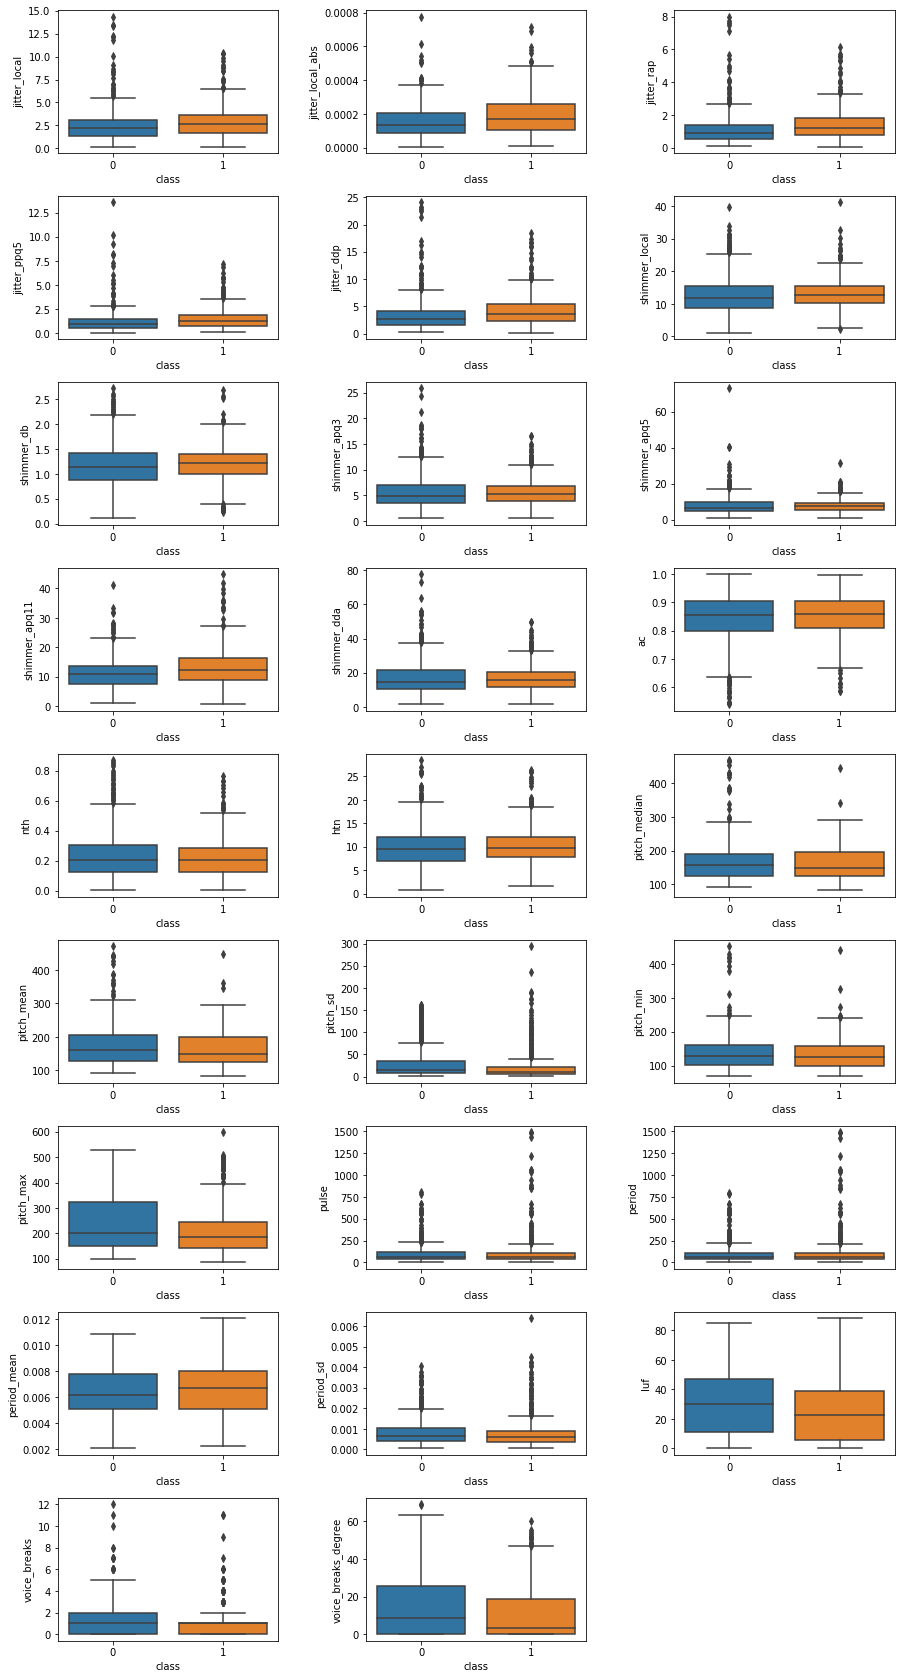

In [5]:
boxplot(df_parkinson,df_parkinson.columns[1:-2])

Aparentemente não há nenhuma diferença grande entre pessoas com/sem parkinson para cada um dos atributos. O boxplot apresenta alguns pontos distantes para alguns atributos mas por enquanto acredito ser normal tal variabilidade.

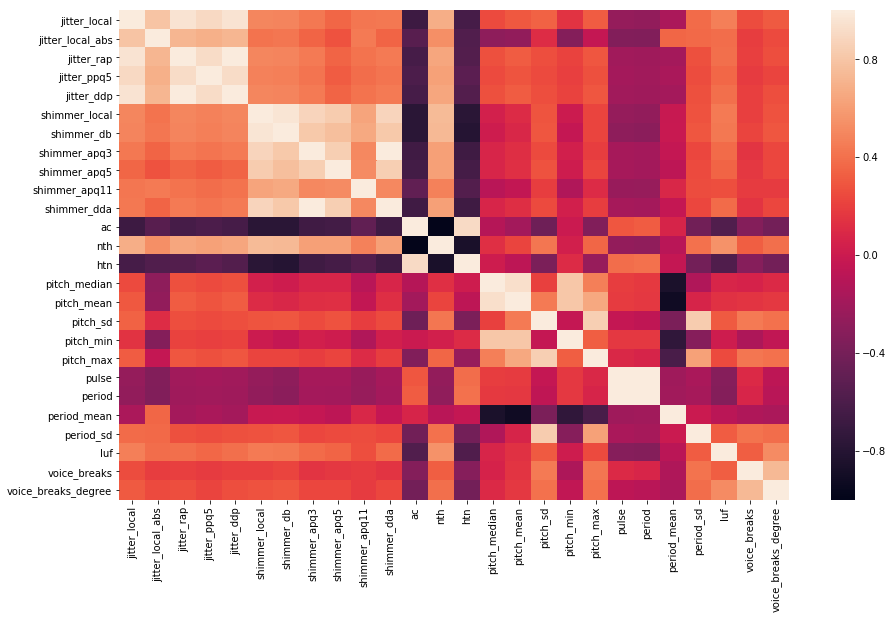

In [6]:
#Correlação entre as variáveis
corr = df_parkinson.iloc[:,1:-2].corr()
plt.figure(figsize=(15,9))
sns.heatmap(corr,vmin=-1,vmax=1)
plt.show()

Em geral as variáveis de um mesmo grupo estão correlacionadas.

In [7]:
def distplot(df,cols):
        
    #Numero de colunas e linhas a serem plotadas
    ncol = 3
    nrow = int(len(cols)/ncol) + 1
    
    #Plota os boxplots em separados
    plt.figure(figsize=(15,30))
    plt.subplots_adjust(wspace=0.4,hspace=0.3)
    for index,c in enumerate(cols):
        plt.subplot(nrow,ncol,index+1)
        sns.distplot(a=df_parkinson[c],hist=False)
    plt.show() 

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


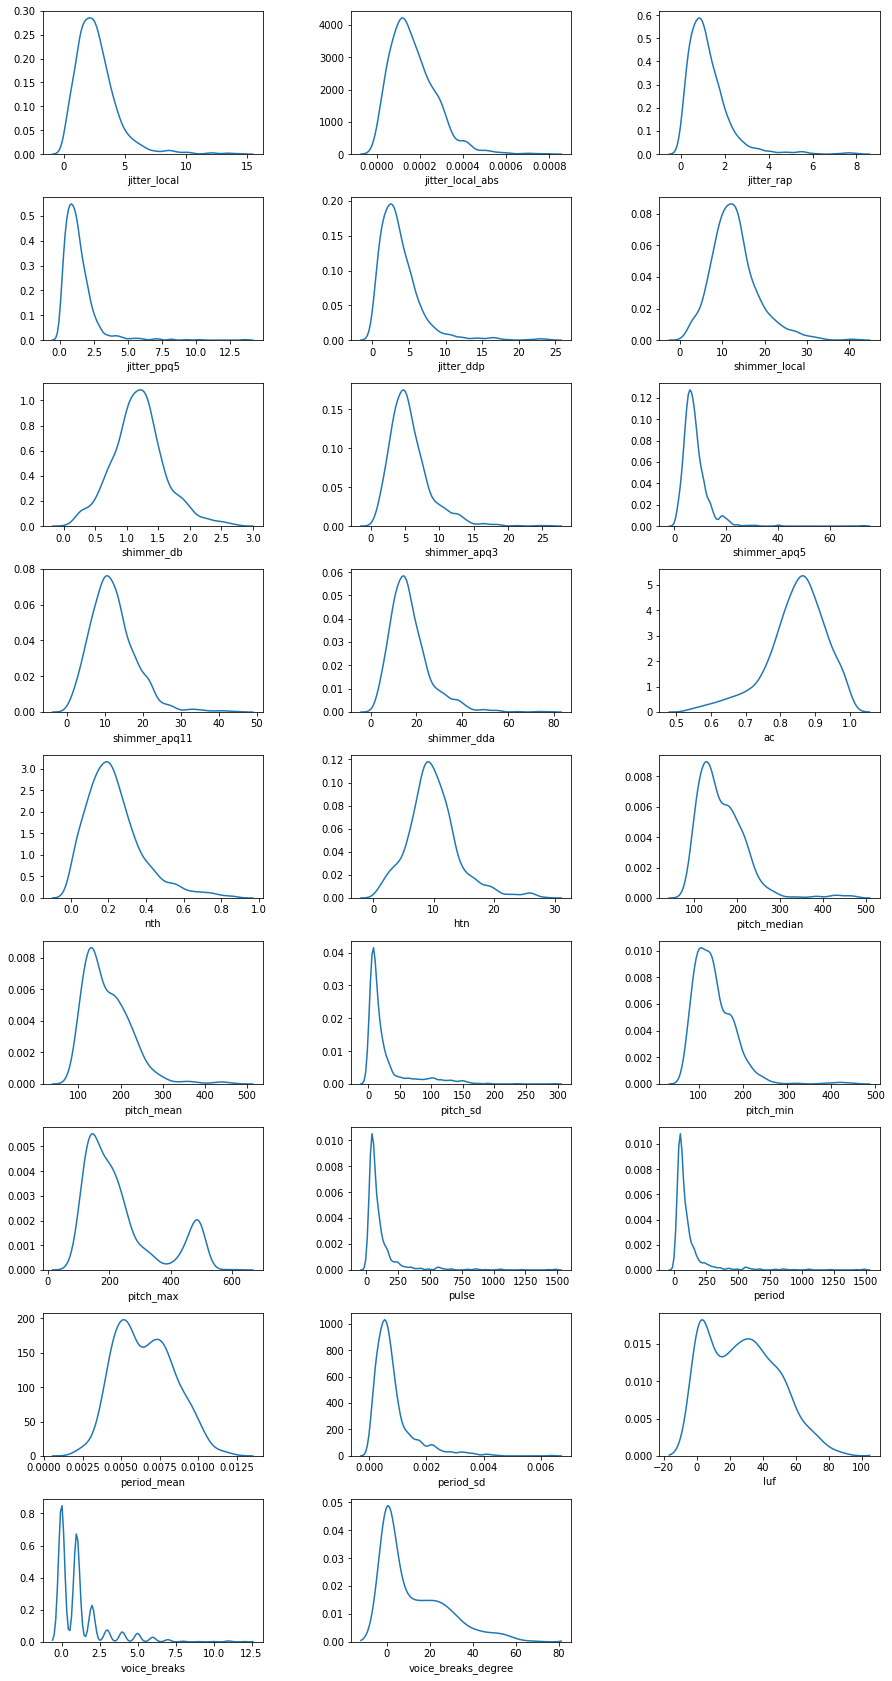

In [8]:
distplot(df_parkinson,df_parkinson.columns[1:-2])

A grande maioria das distribuições são assimétricas.

# 3. Criação de novas métricas

Como temos 26 amostras de som para cada pessoa o ideal seria trabalhar com alguma resumo dessas medidas. Por causa disso iremos utilizar a média e mediana que são estatísticas de tendência central. 

Observação: Tentou-se utilizar tambem outras métricas como desvio padrão, iqr, etc, contudo, observou-se que elas não adicionavam informação final na classificação.

In [9]:
'''Realiza a criação de novas métricas'''
def new_metrics(df,cols):
    
    #Resumo das métricas
    df_new_metric = df.loc[:,cols].groupby('id').agg([np.mean,np.median]).reset_index()

    #Arrumando colunas
    cols = []
    for c in  df_new_metric.columns:
        cols.append(c[0]+'_'+c[1])
    cols[0] = 'id'
    df_new_metric.columns = cols

    #Dicionarion indicando quais pessoas possuem parkinson ou nao
    map_parkinson = df.set_index('id')['class'].to_dict()

    #Mapeamento
    df_new_metric['class'] = df_new_metric['id'].map(map_parkinson)
    
    return df_new_metric

In [10]:
#Criando novas metricas
df_new_metric = new_metrics(df_parkinson,df_parkinson.columns[0:-2])

In [11]:
#Quantidade de atributos
len(df_new_metric.columns[1:-1])

52

In [12]:
#Quantidade de amostras
df_new_metric.shape[0]

40

Fazendo esse resumo acabamos criando novos atributos, tendo um total de 52 valores. Como temos apenas 40 amostras, estamos em um caso clássico do "mal da dimensionalidade" (https://en.wikipedia.org/wiki/Curse_of_dimensionality).

Ou seja, temos mais atributos do que amostras e isso certamente causará um overffiting. Além do mais, não é interessante usar tantos parâmetros assim para realizar uma previsão, o ideal é realizar a melhor classificação com menos atributos possíveis.

Por causa disso, iremos aplicar o PCA para realizar uma redução de dimensionalidade.

In [13]:
#Criando pca
pca = PCA().fit(preprocessing.scale(df_new_metric.iloc[:,1:-1]))

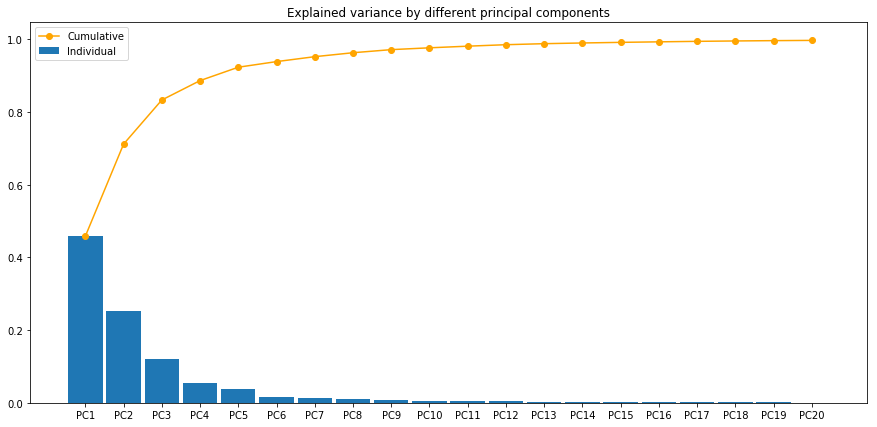

In [14]:
'''Plot da variância explicada do PCA'''
def plot_pca(pca,size):
    #Plot dos 'size' primeiros PC's
    x_list = []
    for i in range(size):
        x_list.append('PC' + str(i+1))

    plt.figure(figsize=(15,7))
    plt.title('Explained variance by different principal components')
    plt.bar(height=pca.explained_variance_ratio_[0:size],x=x_list,width=0.9,label='Individual')
    plt.plot(x_list,np.cumsum(pca.explained_variance_ratio_[0:size]),marker='o',color='orange',label='Cumulative')
    plt.legend()
    plt.show()
    
plot_pca(pca,20)

Pelo gráfico podemos ver que com 8 PC explicamos praticamente toda a variação nos dados. Por causa disso, iremos utilizar daqui em diante 8 componentes. Note que a adição de mais PC's não vale a pena, vide que o aumento de complexidade não compensa o ganho de informação.

In [15]:
'''Aplica o PCA no dataframe.'''
def apply_pca(df,cols,size):
    #Criando pca
    return PCA().fit_transform(preprocessing.scale(df.loc[:,cols]))[:,0:size]

# 4. Modelagem

Na modelagem iremos considerar os seguintes classificadores:

- Árvore de decisão.
- SVM.
- Regressão Logística.
- Knn
- XGB.
- Random Forest.

Como métrica de avaliação, além de olhar a acurácia também estamos interessados na sensibilidade e especificidade do modelo pois o que desejamos é um equilíbro de acerto nas duas classes (pessoas com e sem Parkinson).

In [16]:
'''Perform training in several classifiers'''
def training(X,Y):
    
    #Classifiers
    dt = DecisionTreeClassifier()
    svm = SVC(gamma='scale',probability=True)
    lr = LogisticRegression(solver='liblinear')
    knn_3 = KNeighborsClassifier(n_neighbors=3)
    knn_5 = KNeighborsClassifier(n_neighbors=5)
    knn_7 = KNeighborsClassifier(n_neighbors=7)
    knn_9 = KNeighborsClassifier(n_neighbors=9)
    xgb = XGBClassifier()
    rf = RandomForestClassifier(n_estimators=100)
    
    
    clfs = {'dt':dt,'svm':svm,'lr':lr,'knn_3':knn_3,'knn_5':knn_5,'knn_7':knn_7,'knn_9':knn_9,'xgb':xgb,'rf':rf}

    #Training
    for k,v in clfs.items():
        clfs[k] = v.fit(X,Y)
    
    return clfs

'''Compute some metrics about classification'''
def metrics(clfs,X,Y):
    #Confusion matrix for each classifier
    result = []
    for k in clfs.keys():
        tn, fp, fn, tp  = confusion_matrix(Y,clfs[k].predict(X)).ravel()
        result.append({'classifier':k,'acc':round((tn+tp)/(tn+fp+fn+tp),2),'sens':round(tp/(tp+fn),2),'spec':round(tn/(tn+fp),2),'auc':round(roc_auc_score(Y,clfs[k].predict(X)),2)})
        
    return result

'''Perform an avaliation on classifiers'''
def evaluate_classifiers(X,Y,test_size=0.3):
    
    #Dataframe with classification result
    df_result = pd.DataFrame()
    
    for i in range(50):
        #Split data
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=test_size)
        
        #Training
        clfs = training(X_train,Y_train)

        #Concat other results
        df_result = pd.concat([df_result,pd.DataFrame(metrics(clfs,X_test,Y_test))])

    #Summarizes the metrics
    df_result = df_result.pivot_table(index='classifier',values=['acc','auc','sens','spec'])
    
    #Sort by auc
    df_result.sort_values(by='auc',ascending=False,inplace=True)
    
    return df_result

In [17]:
#Avaliando classificadores
X = apply_pca(df_new_metric,df_new_metric.columns[1:-1],8)
Y = df_new_metric['class']
evaluate_classifiers(X,Y)

,acc,auc,sens,spec
classifier,,,,
lr,0.6620,0.6550,0.6158,0.6924
rf,0.6382,0.6478,0.5796,0.7146
svm,0.6282,0.6454,0.5956,0.6934
xgb,0.6314,0.6386,0.5728,0.7038
knn_9,0.6220,0.6384,0.5566,0.7176
dt,0.6120,0.6160,0.5646,0.6664
knn_7,0.5902,0.6108,0.4788,0.7438
knn_5,0.5556,0.5690,0.4434,0.6954
knn_3,0.5424,0.5606,0.4014,0.7192


Pela tabela acima note que a regressão logística foi o modelo que obteve o melhor equilíbrio dentre as métricas e é aquele que também possui o maior AUC.

Por causa disso vamos nos aprofundar um pouco mais nesse modelo utilizando o Lasso como método de regularização nos dados sem PCA para entender quais variáveis são as mais significantes na classificação.

In [18]:
#Regressão logística com Lasso
X = df_new_metric.iloc[:,1:-1]
Y = df_new_metric['class']
lr = LogisticRegression(solver='liblinear',penalty='l1',max_iter=200).fit(X,Y)

In [19]:
#Colunas relevantes para a classificacao
relevant_cols = df_new_metric.iloc[:,1:-1].columns[lr.coef_[0] != 0].values
relevant_cols

array(['jitter_ddp_median', 'shimmer_apq11_mean', 'shimmer_dda_median',
       'htn_mean', 'pitch_median_mean', 'pitch_mean_median',
       'pitch_sd_mean', 'pitch_sd_median', 'pitch_min_mean',
       'pitch_max_mean', 'pitch_max_median', 'pulse_median',
       'period_mean', 'luf_mean', 'voice_breaks_degree_mean'],
      dtype=object)

Muitos estudos sugerem que há uma disfonia na voz de pessoas com Parkinson, afetando principalmente a amplitude e frequencia da fala, fato que podemos ver aqui por jitter e shimmer serem atributos relevantes.

Além disso, é interessante notar que temos muitos valores do grupo pitch (tom). Esse valor não é muito reportado na litetura, de qualquer forma é interessante notar que pessoas com Parkison podem ter tons diferentes na fala comparado a pessoas saudaveis.

# 5. Validação

Vamos avaliar a regressão logística com Lasso no conjunto de teste.

In [20]:
#Nome das colunas
names_train = ['id','jitter_local','jitter_local_abs','jitter_rap','jitter_ppq5','jitter_ddp','shimmer_local',
 'shimmer_db','shimmer_apq3','shimmer_apq5','shimmer_apq11','shimmer_dda','ac','nth','htn',
'pitch_median','pitch_mean','pitch_sd','pitch_min','pitch_max','pulse','period',
'period_mean','period_sd','luf','voice_breaks','voice_breaks_degree','UPDRS','class']
names_test = ['id','jitter_local','jitter_local_abs','jitter_rap','jitter_ppq5','jitter_ddp','shimmer_local',
 'shimmer_db','shimmer_apq3','shimmer_apq5','shimmer_apq11','shimmer_dda','ac','nth','htn',
'pitch_median','pitch_mean','pitch_sd','pitch_min','pitch_max','pulse','period',
'period_mean','period_sd','luf','voice_breaks','voice_breaks_degree','class']

#Leitura
df_train = pd.read_csv('train_data.txt',header=None,names=names_train)
df_test = pd.read_csv('test_data.txt',header=None,names=names_test)

In [21]:
#Criacao das metricas
df_train = new_metrics(df_train,df_train.columns[0:-2])
df_test = new_metrics(df_test,df_test.columns[0:-1])

#Colocanco classe nas colunas relevantes
relevant_cols = np.append(relevant_cols,'class')

#Selecao das colunas relevantes
df_train = df_train.loc[:,relevant_cols]
df_test = df_test.loc[:,relevant_cols]

In [22]:
#Treinamento
X_train = df_train.iloc[:,0:-1]
Y_train = df_train['class']
lr = LogisticRegression(solver='liblinear',penalty='l1',max_iter=200).fit(X_train,Y_train)

In [23]:
#Test
X_test = df_test.iloc[:,0:-1]
Y_test = df_test['class']
lr.score(X_test,Y_test)

0.8571428571428571

# 6. Conclusão

A regressão logística acabou sendo o modelo mais promissor dentro todos os classificadores por ser aquele mais equilibrado quanto a sensibilidade e especificidade.

Foi possível verificar que existe uma diferença na voz de pessoas doentes x saudáveis sendo que a frequência, amplitude e tom aparentam ser atributos relevantes nessa discretização.

Nosso classificador conseguiu uma acurácia de 85% no teste, o que já é um bom resultado dado que na litetura temos que os médicos possuem um acerto de aproximadamente 75% no diagnóstico. Contudo, salientamos que nosso conjunto de teste possui apenas dados de pessoas com Parkison, então não foi possível avaliar o real poder de generalização do algoritmo. Mesmo assim, se o objetivo é central é prever que uma pessoa doente realmente possui Parkison, então a regressão logística proposta faz um bom trabalho.

Por fim, concluímos que amostras de voz podem ser realmente úteis para os médicos quanto ao diagnóstico de Parkison e certamente possui um futuro promissor dado que é fácil realizar tal coleta nos pacientes.